In [ ]:

# Load required libraries and datasets
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from collections import Counter
import warnings
warnings.filterwarnings('ignore')

# Set display options for better readability
pd.set_option('display.max_columns', None)
pd.set_option('display.max_colwidth', 50)

print("Loading datasets...")
# Load Hybrid 2.0 and 3.0 designs
hybrid_20_df = pd.read_csv('hybrid_2.0_designs.csv')
hybrid_30_df = pd.read_csv('hybrid_3.0_designs.csv')

# Load previous top 100 for comparison
previous_top100 = pd.read_csv('definitive_top_100_candidates_v2.csv')

print(f"Hybrid 2.0 designs loaded: {len(hybrid_20_df)} entries")
print(f"Hybrid 3.0 designs loaded: {len(hybrid_30_df)} entries")
print(f"Previous top 100 loaded: {len(previous_top100)} entries")

# Display column names to understand structure
print("\nHybrid 2.0 columns:", hybrid_20_df.columns.tolist())
print("\nHybrid 3.0 columns:", hybrid_30_df.columns.tolist())


Loading datasets...
Hybrid 2.0 designs loaded: 44343 entries
Hybrid 3.0 designs loaded: 1368 entries
Previous top 100 loaded: 100 entries

Hybrid 2.0 columns: ['Scaffold', 'Loop_Position', 'Loop_Range', 'Parent_Subsequence', 'Double_Mutant_Sequence', 'Mutations', 'Design_Sequence', 'Motif_MJ_Score', 'Motif_Length']

Hybrid 3.0 columns: ['Scaffold', 'Loop_Position', 'Loop_Range', 'Parent_Subsequence', 'Double_Mutant_Sequence', 'Triple_Mutant_Sequence', 'Mutations', 'Third_Mutation', 'Design_Sequence', 'Motif_Length', 'Motif_MJ_Score']


In [ ]:

# Examine sample data to understand the structure
print("Sample Hybrid 2.0 data:")
print(hybrid_20_df.head(3))
print("\n" + "="*80 + "\n")

print("Sample Hybrid 3.0 data:")
print(hybrid_30_df.head(3))
print("\n" + "="*80 + "\n")

print("Sample previous top 100 data:")
print(previous_top100.head(3))

# Check unique motif lengths
print("\n" + "="*80 + "\n")
print(f"Hybrid 2.0 motif lengths: {sorted(hybrid_20_df['Motif_Length'].unique())}")
print(f"Hybrid 3.0 motif lengths: {sorted(hybrid_30_df['Motif_Length'].unique())}")


Sample Hybrid 2.0 data:
  Scaffold  Loop_Position Loop_Range Parent_Subsequence  \
0     1FNA              1      25-33          RASQGIIDY   
1     1FNA              2      40-48          RASQGIIDY   
2     1FNA              3      60-68          RASQGIIDY   

  Double_Mutant_Sequence Mutations  \
0              QSSQGIIDY   R1Q,A2S   
1              QSSQGIIDY   R1Q,A2S   
2              QSSQGIIDY   R1Q,A2S   

                                     Design_Sequence  Motif_MJ_Score  \
0  RDLEVVAATPARDYQYYYPAVTVRQSSQGIIDYGGNSPVQEFTVPG...          -86.13   
1  RDLEVVAATPTSLLISWDAPAVTVRYYRITYGETGARDYQSSQGII...          -86.13   
2  RDLEVVAATPTSLLISWDAPAVTVRYYRITYGETGGNSPVQEFTVP...          -86.13   

   Motif_Length  
0             9  
1             9  
2             9  


Sample Hybrid 3.0 data:
  Scaffold  Loop_Position Loop_Range Parent_Subsequence  \
0     1FNA              1      25-33          VHDYGISFM   
1     1FNA              2      40-48          VHDYGISFM   
2     1FNA            

In [ ]:

# Define the precise 111-residue allosteric epitope
allosteric_epitope_111 = "LAKIGEIGKVSLIDSSTTIPNILGSKISSTSINENVNKCKFTLPPLKIHECNISCPRTGVGLPNNICLQSYTLPVVGQSKEVLDRGSLFMQLGQPDVLTVNDRINIKKNKE"

print(f"111-residue allosteric epitope loaded")
print(f"Length: {len(allosteric_epitope_111)} residues")
print(f"Sequence: {allosteric_epitope_111}")

# Verify it matches what was described
assert len(allosteric_epitope_111) == 111, "Epitope length mismatch!"
print("\n✓ Epitope length verified")


111-residue allosteric epitope loaded
Length: 111 residues
Sequence: LAKIGEIGKVSLIDSSTTIPNILGSKISSTSINENVNKCKFTLPPLKIHECNISCPRTGVGLPNNICLQSYTLPVVGQSKEVLDRGSLFMQLGQPDVLTVNDRINIKKNKE

✓ Epitope length verified


In [ ]:

# Implement Miyazawa-Jernigan scoring function
# Load the MJ matrix (standard 20x20 amino acid interaction matrix)

# Standard MJ matrix values (contact energy in kcal/mol)
MJ_MATRIX = {
    ('A', 'A'): -0.11, ('A', 'C'): -0.52, ('A', 'D'): -0.28, ('A', 'E'): -0.09, ('A', 'F'): -0.42,
    ('A', 'G'): 0.01, ('A', 'H'): -0.26, ('A', 'I'): -0.39, ('A', 'K'): -0.13, ('A', 'L'): -0.34,
    ('A', 'M'): -0.30, ('A', 'N'): -0.15, ('A', 'P'): 0.09, ('A', 'Q'): -0.10, ('A', 'R'): -0.16,
    ('A', 'S'): 0.00, ('A', 'T'): -0.07, ('A', 'V'): -0.28, ('A', 'W'): -0.36, ('A', 'Y'): -0.28,
    ('C', 'C'): -1.44, ('C', 'D'): -0.97, ('C', 'E'): -0.74, ('C', 'F'): -0.87, ('C', 'G'): -0.78,
    ('C', 'H'): -0.81, ('C', 'I'): -0.76, ('C', 'K'): -0.80, ('C', 'L'): -0.78, ('C', 'M'): -0.79,
    ('C', 'N'): -0.87, ('C', 'P'): -0.68, ('C', 'Q'): -0.73, ('C', 'R'): -0.76, ('C', 'S'): -0.64,
    ('C', 'T'): -0.62, ('C', 'V'): -0.72, ('C', 'W'): -0.93, ('C', 'Y'): -0.85, ('D', 'D'): 0.06,
    ('D', 'E'): 0.11, ('D', 'F'): -0.49, ('D', 'G'): -0.07, ('D', 'H'): -0.28, ('D', 'I'): -0.40,
    ('D', 'K'): -0.03, ('D', 'L'): -0.47, ('D', 'M'): -0.40, ('D', 'N'): 0.06, ('D', 'P'): -0.11,
    ('D', 'Q'): 0.03, ('D', 'R'): -0.07, ('D', 'S'): 0.06, ('D', 'T'): 0.00, ('D', 'V'): -0.37,
    ('D', 'W'): -0.56, ('D', 'Y'): -0.38, ('E', 'E'): 0.14, ('E', 'F'): -0.42, ('E', 'G'): -0.01,
    ('E', 'H'): -0.17, ('E', 'I'): -0.34, ('E', 'K'): 0.06, ('E', 'L'): -0.39, ('E', 'M'): -0.30,
    ('E', 'N'): 0.08, ('E', 'P'): -0.04, ('E', 'Q'): 0.11, ('E', 'R'): 0.00, ('E', 'S'): 0.09,
    ('E', 'T'): 0.05, ('E', 'V'): -0.31, ('E', 'W'): -0.47, ('E', 'Y'): -0.32, ('F', 'F'): -1.01,
    ('F', 'G'): -0.62, ('F', 'H'): -0.67, ('F', 'I'): -0.80, ('F', 'K'): -0.53, ('F', 'L'): -0.85,
    ('F', 'M'): -0.78, ('F', 'N'): -0.56, ('F', 'P'): -0.54, ('F', 'Q'): -0.52, ('F', 'R'): -0.54,
    ('F', 'S'): -0.48, ('F', 'T'): -0.47, ('F', 'V'): -0.74, ('F', 'W'): -0.88, ('F', 'Y'): -0.75,
    ('G', 'G'): 0.14, ('G', 'H'): -0.23, ('G', 'I'): -0.44, ('G', 'K'): -0.11, ('G', 'L'): -0.51,
    ('G', 'M'): -0.42, ('G', 'N'): -0.07, ('G', 'P'): -0.11, ('G', 'Q'): -0.09, ('G', 'R'): -0.15,
    ('G', 'S'): 0.03, ('G', 'T'): -0.05, ('G', 'V'): -0.37, ('G', 'W'): -0.59, ('G', 'Y'): -0.44,
    ('H', 'H'): -0.44, ('H', 'I'): -0.56, ('H', 'K'): -0.19, ('H', 'L'): -0.58, ('H', 'M'): -0.51,
    ('H', 'N'): -0.17, ('H', 'P'): -0.25, ('H', 'Q'): -0.17, ('H', 'R'): -0.19, ('H', 'S'): -0.13,
    ('H', 'T'): -0.16, ('H', 'V'): -0.48, ('H', 'W'): -0.56, ('H', 'Y'): -0.45, ('I', 'I'): -0.72,
    ('I', 'K'): -0.38, ('I', 'L'): -0.76, ('I', 'M'): -0.68, ('I', 'N'): -0.42, ('I', 'P'): -0.43,
    ('I', 'Q'): -0.37, ('I', 'R'): -0.38, ('I', 'S'): -0.33, ('I', 'T'): -0.32, ('I', 'V'): -0.65,
    ('I', 'W'): -0.75, ('I', 'Y'): -0.63, ('K', 'K'): 0.01, ('K', 'L'): -0.44, ('K', 'M'): -0.36,
    ('K', 'N'): 0.00, ('K', 'P'): -0.16, ('K', 'Q'): 0.02, ('K', 'R'): 0.03, ('K', 'S'): -0.04,
    ('K', 'T'): -0.05, ('K', 'V'): -0.35, ('K', 'W'): -0.51, ('K', 'Y'): -0.39, ('L', 'L'): -0.85,
    ('L', 'M'): -0.75, ('L', 'N'): -0.49, ('L', 'P'): -0.48, ('L', 'Q'): -0.43, ('L', 'R'): -0.44,
    ('L', 'S'): -0.37, ('L', 'T'): -0.36, ('L', 'V'): -0.70, ('L', 'W'): -0.83, ('L', 'Y'): -0.68,
    ('M', 'M'): -0.72, ('M', 'N'): -0.41, ('M', 'P'): -0.41, ('M', 'Q'): -0.34, ('M', 'R'): -0.36,
    ('M', 'S'): -0.29, ('M', 'T'): -0.29, ('M', 'V'): -0.61, ('M', 'W'): -0.76, ('M', 'Y'): -0.61,
    ('N', 'N'): 0.08, ('N', 'P'): -0.17, ('N', 'Q'): 0.04, ('N', 'R'): -0.01, ('N', 'S'): 0.05,
    ('N', 'T'): 0.03, ('N', 'V'): -0.39, ('N', 'W'): -0.58, ('N', 'Y'): -0.40, ('P', 'P'): -0.21,
    ('P', 'Q'): -0.10, ('P', 'R'): -0.14, ('P', 'S'): -0.07, ('P', 'T'): -0.08, ('P', 'V'): -0.34,
    ('P', 'W'): -0.52, ('P', 'Y'): -0.39, ('Q', 'Q'): 0.07, ('Q', 'R'): 0.04, ('Q', 'S'): 0.04,
    ('Q', 'T'): 0.02, ('Q', 'V'): -0.35, ('Q', 'W'): -0.51, ('Q', 'Y'): -0.37, ('R', 'R'): 0.06,
    ('R', 'S'): -0.01, ('R', 'T'): -0.03, ('R', 'V'): -0.36, ('R', 'W'): -0.52, ('R', 'Y'): -0.39,
    ('S', 'S'): 0.05, ('S', 'T'): 0.04, ('S', 'V'): -0.25, ('S', 'W'): -0.48, ('S', 'Y'): -0.33,
    ('T', 'T'): 0.01, ('T', 'V'): -0.25, ('T', 'W'): -0.48, ('T', 'Y'): -0.33, ('V', 'V'): -0.61,
    ('V', 'W'): -0.72, ('V', 'Y'): -0.58, ('W', 'W'): -1.20, ('W', 'Y'): -0.87, ('Y', 'Y'): -0.69
}

def calculate_mj_score(motif_sequence, target_sequence):
    """
    Calculate Miyazawa-Jernigan interaction score between a motif and target sequence.
    More negative scores indicate stronger predicted binding.
    
    Parameters:
    - motif_sequence: The binder motif sequence
    - target_sequence: The epitope sequence
    
    Returns:
    - Total MJ interaction score (sum of all pairwise interactions)
    """
    total_score = 0.0
    
    for motif_aa in motif_sequence:
        for target_aa in target_sequence:
            # MJ matrix is symmetric, so order doesn't matter
            key = tuple(sorted([motif_aa, target_aa]))
            if key in MJ_MATRIX:
                total_score += MJ_MATRIX[key]
            # If amino acid not in matrix (shouldn't happen for standard AAs), skip
    
    return total_score

print("✓ MJ scoring function implemented")
print(f"✓ MJ matrix contains {len(MJ_MATRIX)} interaction pairs")


✓ MJ scoring function implemented
✓ MJ matrix contains 210 interaction pairs


In [ ]:

# Extract unique motifs from both datasets
# For Hybrid 2.0: use Double_Mutant_Sequence
# For Hybrid 3.0: use Triple_Mutant_Sequence

print("Extracting unique motifs from both datasets...")

# Hybrid 2.0 motifs
h20_motifs = hybrid_20_df['Double_Mutant_Sequence'].unique()
print(f"Unique Hybrid 2.0 motifs: {len(h20_motifs)}")

# Hybrid 3.0 motifs
h30_motifs = hybrid_30_df['Triple_Mutant_Sequence'].unique()
print(f"Unique Hybrid 3.0 motifs: {len(h30_motifs)}")

# Combined unique motifs
all_motifs = set(h20_motifs) | set(h30_motifs)
print(f"Total unique motifs across both datasets: {len(all_motifs)}")

# Check for overlap
overlap = set(h20_motifs) & set(h30_motifs)
print(f"Motifs present in both datasets: {len(overlap)}")


Extracting unique motifs from both datasets...
Unique Hybrid 2.0 motifs: 4927
Unique Hybrid 3.0 motifs: 136
Total unique motifs across both datasets: 5063
Motifs present in both datasets: 0


In [ ]:

# Calculate MJ scores for all unique motifs against the 111-residue epitope
print("Calculating MJ scores for all unique motifs against 111-residue allosteric epitope...")
print("This may take a few minutes...\n")

# Create a dictionary to store motif -> score mappings
motif_scores = {}

# Calculate scores for all unique motifs
for i, motif in enumerate(all_motifs):
    score = calculate_mj_score(motif, allosteric_epitope_111)
    motif_scores[motif] = score
    
    # Progress indicator
    if (i + 1) % 500 == 0:
        print(f"Processed {i + 1}/{len(all_motifs)} motifs...")

print(f"\n✓ Calculated MJ scores for {len(motif_scores)} unique motifs")

# Show score distribution
scores_array = np.array(list(motif_scores.values()))
print(f"\nScore statistics:")
print(f"  Mean: {scores_array.mean():.2f}")
print(f"  Std: {scores_array.std():.2f}")
print(f"  Min (best): {scores_array.min():.2f}")
print(f"  Max (worst): {scores_array.max():.2f}")


Calculating MJ scores for all unique motifs against 111-residue allosteric epitope...
This may take a few minutes...

Processed 500/5063 motifs...


Processed 1000/5063 motifs...
Processed 1500/5063 motifs...


Processed 2000/5063 motifs...
Processed 2500/5063 motifs...


Processed 3000/5063 motifs...
Processed 3500/5063 motifs...


Processed 4000/5063 motifs...
Processed 4500/5063 motifs...


Processed 5000/5063 motifs...

✓ Calculated MJ scores for 5063 unique motifs

Score statistics:
  Mean: -309.07
  Std: 44.80
  Min (best): -419.68
  Max (worst): -198.65


In [ ]:

# Map scores back to the full datasets
print("Mapping scores back to full design datasets...")

# For Hybrid 2.0: map Double_Mutant_Sequence -> score
hybrid_20_df['Refined_MJ_Score'] = hybrid_20_df['Double_Mutant_Sequence'].map(motif_scores)

# For Hybrid 3.0: map Triple_Mutant_Sequence -> score
hybrid_30_df['Refined_MJ_Score'] = hybrid_30_df['Triple_Mutant_Sequence'].map(motif_scores)

# Verify no missing scores
print(f"Hybrid 2.0 missing scores: {hybrid_20_df['Refined_MJ_Score'].isna().sum()}")
print(f"Hybrid 3.0 missing scores: {hybrid_30_df['Refined_MJ_Score'].isna().sum()}")

# Add strategy labels
hybrid_20_df['Design_Strategy'] = 'Hybrid_2.0'
hybrid_30_df['Design_Strategy'] = 'Hybrid_3.0'

# Add motif column for consistency
hybrid_20_df['Motif'] = hybrid_20_df['Double_Mutant_Sequence']
hybrid_30_df['Motif'] = hybrid_30_df['Triple_Mutant_Sequence']

print("\n✓ Scores successfully mapped to all designs")


Mapping scores back to full design datasets...
Hybrid 2.0 missing scores: 0
Hybrid 3.0 missing scores: 0

✓ Scores successfully mapped to all designs


In [ ]:

# Consolidate both datasets
print("Consolidating Hybrid 2.0 and 3.0 datasets...")

# Select relevant columns for consolidation
h20_subset = hybrid_20_df[['Design_Sequence', 'Design_Strategy', 'Motif', 'Refined_MJ_Score', 
                            'Scaffold', 'Loop_Position', 'Loop_Range']].copy()

h30_subset = hybrid_30_df[['Design_Sequence', 'Design_Strategy', 'Motif', 'Refined_MJ_Score',
                            'Scaffold', 'Loop_Position', 'Loop_Range']].copy()

# Combine datasets
consolidated_df = pd.concat([h20_subset, h30_subset], ignore_index=True)

print(f"Total consolidated designs: {len(consolidated_df)}")
print(f"  Hybrid 2.0: {len(h20_subset)}")
print(f"  Hybrid 3.0: {len(h30_subset)}")

# Sort by Refined_MJ_Score (most negative = best binding)
consolidated_df = consolidated_df.sort_values('Refined_MJ_Score', ascending=True).reset_index(drop=True)

print("\n✓ Datasets consolidated and sorted")
print(f"\nTop 10 scores (best binders):")
print(consolidated_df[['Design_Strategy', 'Motif', 'Refined_MJ_Score']].head(10))


Consolidating Hybrid 2.0 and 3.0 datasets...
Total consolidated designs: 45711
  Hybrid 2.0: 44343
  Hybrid 3.0: 1368

✓ Datasets consolidated and sorted

Top 10 scores (best binders):
  Design_Strategy      Motif  Refined_MJ_Score
0      Hybrid_3.0  LYDFGISFM           -419.68
1      Hybrid_3.0  LYDFGISFM           -419.68
2      Hybrid_3.0  LYDFGISFM           -419.68
3      Hybrid_3.0  LYDFGISFM           -419.68
4      Hybrid_3.0  LYDFGISFM           -419.68
5      Hybrid_3.0  LYDFGISFM           -419.68
6      Hybrid_3.0  LYDFGISFM           -419.68
7      Hybrid_3.0  LYDFGISFM           -419.68
8      Hybrid_3.0  LYDFGISFM           -419.68
9      Hybrid_3.0  LYDFGISFM           -419.68


In [ ]:

# Extract top 100 designs
print("Extracting top 100 candidates...")

top_100_df = consolidated_df.head(100).copy()
top_100_df['Final_Rank'] = range(1, 101)

# Reorder columns for final output
top_100_df = top_100_df[['Final_Rank', 'Design_Sequence', 'Design_Strategy', 
                          'Motif', 'Refined_MJ_Score', 'Scaffold', 'Loop_Position', 'Loop_Range']]

# Rename Design_Sequence to Sequence for consistency with previous format
top_100_df = top_100_df.rename(columns={'Design_Sequence': 'Sequence'})

print(f"✓ Top 100 candidates extracted")
print(f"\nFirst 5 candidates:")
print(top_100_df.head())


Extracting top 100 candidates...
✓ Top 100 candidates extracted

First 5 candidates:
   Final_Rank                                           Sequence  \
0           1  MQYKLILNGKTLKGETTTEAVDAATAEKVFKQYANDNGVDGEWTLY...   
1           2  MQYKLILNGKTLKGETTTEAVDAATAEKVLYDFGISFMDGEWTYDD...   
2           3  RLDAPSQIEVKDVTDTTALITWFKPLAEIDGIELTYGIKDVPGDRT...   
3           4  RDLEVVAATPTSLLISWDAPAVTVRYYRITYGETGGNSPVQEFTVP...   
4           5  MQYKLILNARDYQYLYDFGISFMTAEKVFKQYANDNGVDGEWTYDD...   

  Design_Strategy      Motif  Refined_MJ_Score Scaffold  Loop_Position  \
0      Hybrid_3.0  LYDFGISFM           -419.68     2QMT              3   
1      Hybrid_3.0  LYDFGISFM           -419.68     2QMT              2   
2      Hybrid_3.0  LYDFGISFM           -419.68     1TEN              3   
3      Hybrid_3.0  LYDFGISFM           -419.68     1FNA              3   
4      Hybrid_3.0  LYDFGISFM           -419.68     2QMT              1   

  Loop_Range  
0      45-53  
1      30-38  
2      55-63  
3

In [ ]:

# Analyze the composition of the top 100 list
print("="*80)
print("COMPOSITION ANALYSIS OF NEW TOP 100")
print("="*80)

# Count by strategy
strategy_counts = top_100_df['Design_Strategy'].value_counts()
print("\nDesign Strategy Distribution:")
for strategy, count in strategy_counts.items():
    percentage = (count / len(top_100_df)) * 100
    print(f"  {strategy}: {count} ({percentage:.1f}%)")

# Unique motifs in top 100
unique_motifs = top_100_df['Motif'].nunique()
print(f"\nUnique motifs in top 100: {unique_motifs}")

# Top motifs
print("\nTop 10 most frequent motifs in top 100:")
motif_counts = top_100_df['Motif'].value_counts().head(10)
for motif, count in motif_counts.items():
    score = top_100_df[top_100_df['Motif'] == motif]['Refined_MJ_Score'].iloc[0]
    print(f"  {motif}: {count} occurrences (score: {score:.2f})")

# Score range
print(f"\nScore range in new top 100:")
print(f"  Best (rank 1): {top_100_df['Refined_MJ_Score'].iloc[0]:.2f}")
print(f"  Worst (rank 100): {top_100_df['Refined_MJ_Score'].iloc[-1]:.2f}")
print(f"  Mean: {top_100_df['Refined_MJ_Score'].mean():.2f}")
print(f"  Std: {top_100_df['Refined_MJ_Score'].std():.2f}")


COMPOSITION ANALYSIS OF NEW TOP 100

Design Strategy Distribution:
  Hybrid_3.0: 100 (100.0%)

Unique motifs in top 100: 9

Top 10 most frequent motifs in top 100:
  LYDFGISFM: 18 occurrences (score: -419.68)
  LYDWGISFM: 18 occurrences (score: -418.71)
  VYDFGIAFM: 18 occurrences (score: -414.26)
  VYDFGISFL: 9 occurrences (score: -416.23)
  VYDWGISFL: 9 occurrences (score: -415.26)
  VYDFGLSFM: 9 occurrences (score: -413.64)
  IYDFGISFM: 9 occurrences (score: -413.57)
  VYDFGINFM: 9 occurrences (score: -413.55)
  VYDWGIAFM: 1 occurrences (score: -413.29)

Score range in new top 100:
  Best (rank 1): -419.68
  Worst (rank 100): -413.29
  Mean: -416.11
  Std: 2.46


In [ ]:

# Compare with previous top 100
print("="*80)
print("COMPARISON WITH PREVIOUS TOP 100 (v2)")
print("="*80)

# Previous top 100 score statistics
print("\nPrevious top 100 (v2) score statistics:")
print(f"  Scoring method: Residual_Score (length-corrected)")
print(f"  Mean: {previous_top100['Residual_Score'].mean():.2f}")
print(f"  Std: {previous_top100['Residual_Score'].std():.2f}")
print(f"  Min: {previous_top100['Residual_Score'].min():.2f}")
print(f"  Max: {previous_top100['Residual_Score'].max():.2f}")

# Previous top 100 composition
prev_strategy_counts = previous_top100['Design_Strategy'].value_counts()
print("\nPrevious Design Strategy Distribution:")
for strategy, count in prev_strategy_counts.items():
    percentage = (count / len(previous_top100)) * 100
    print(f"  {strategy}: {count} ({percentage:.1f}%)")

print(f"\nMotif comparison:")
print(f"  Previous unique sequences: {previous_top100['Sequence'].nunique()}")
print(f"  New unique motifs: {unique_motifs}")

print("\n" + "="*80)
print("KEY FINDINGS:")
print("="*80)
print(f"✓ New top 100 is 100% Hybrid 3.0 designs (vs 0% in v2)")
print(f"✓ New top 100 has only {unique_motifs} unique motifs (high convergence)")
print(f"✓ Score range: {top_100_df['Refined_MJ_Score'].iloc[0]:.2f} to {top_100_df['Refined_MJ_Score'].iloc[-1]:.2f}")
print(f"✓ All designs scored against consistent 111-residue allosteric epitope")
print(f"✓ Previous v2 used Residual_Score; new v3 uses direct MJ score (different scale)")


COMPARISON WITH PREVIOUS TOP 100 (v2)

Previous top 100 (v2) score statistics:
  Scoring method: Residual_Score (length-corrected)
  Mean: 515.30
  Std: 4.13
  Min: 509.86
  Max: 520.99

Previous Design Strategy Distribution:
  Hybrid_2.0: 100 (100.0%)

Motif comparison:
  Previous unique sequences: 100
  New unique motifs: 9

KEY FINDINGS:
✓ New top 100 is 100% Hybrid 3.0 designs (vs 0% in v2)
✓ New top 100 has only 9 unique motifs (high convergence)
✓ Score range: -419.68 to -413.29
✓ All designs scored against consistent 111-residue allosteric epitope
✓ Previous v2 used Residual_Score; new v3 uses direct MJ score (different scale)


In [ ]:

# Save the definitive top 100 candidates v3 to file
output_file = 'definitive_top_100_candidates_v3.csv'

# Select final columns for output
final_output = top_100_df[['Final_Rank', 'Sequence', 'Design_Strategy', 'Motif', 'Refined_MJ_Score']].copy()

# Save to CSV
final_output.to_csv(output_file, index=False)

print(f"✓ Saved definitive top 100 candidates to {output_file}")
print(f"\nFile contains {len(final_output)} rows and {len(final_output.columns)} columns")
print(f"Columns: {final_output.columns.tolist()}")

# Verify file was saved
import os
if os.path.exists(output_file):
    file_size = os.path.getsize(output_file)
    print(f"✓ File successfully created ({file_size} bytes)")
else:
    print("✗ Error: File was not created")


✓ Saved definitive top 100 candidates to definitive_top_100_candidates_v3.csv

File contains 100 rows and 5 columns
Columns: ['Final_Rank', 'Sequence', 'Design_Strategy', 'Motif', 'Refined_MJ_Score']
✓ File successfully created (12325 bytes)


In [ ]:

# Additional analysis: Compare score distributions between Hybrid 2.0 and 3.0
print("="*80)
print("SCORE DISTRIBUTION COMPARISON: Hybrid 2.0 vs Hybrid 3.0")
print("="*80)

# Get score statistics for each strategy
h20_scores = hybrid_20_df['Refined_MJ_Score'].describe()
h30_scores = hybrid_30_df['Refined_MJ_Score'].describe()

print("\nHybrid 2.0 Score Distribution (n=44,343):")
print(f"  Mean: {h20_scores['mean']:.2f}")
print(f"  Std: {h20_scores['std']:.2f}")
print(f"  Min (best): {h20_scores['min']:.2f}")
print(f"  25th percentile: {h20_scores['25%']:.2f}")
print(f"  Median: {h20_scores['50%']:.2f}")
print(f"  75th percentile: {h20_scores['75%']:.2f}")
print(f"  Max (worst): {h20_scores['max']:.2f}")

print("\nHybrid 3.0 Score Distribution (n=1,368):")
print(f"  Mean: {h30_scores['mean']:.2f}")
print(f"  Std: {h30_scores['std']:.2f}")
print(f"  Min (best): {h30_scores['min']:.2f}")
print(f"  25th percentile: {h30_scores['25%']:.2f}")
print(f"  Median: {h30_scores['50%']:.2f}")
print(f"  75th percentile: {h30_scores['75%']:.2f}")
print(f"  Max (worst): {h30_scores['max']:.2f}")

# Calculate improvement
mean_improvement = h30_scores['mean'] - h20_scores['mean']
best_improvement = h30_scores['min'] - h20_scores['min']

print(f"\nImprovement from Hybrid 2.0 to 3.0:")
print(f"  Mean score improvement: {mean_improvement:.2f} (more negative is better)")
print(f"  Best score improvement: {best_improvement:.2f}")

# Count how many Hybrid 2.0 designs are better than worst Hybrid 3.0
h20_better_than_worst_h30 = (hybrid_20_df['Refined_MJ_Score'] < h30_scores['max']).sum()
print(f"\nHybrid 2.0 designs better than worst Hybrid 3.0: {h20_better_than_worst_h30} ({100*h20_better_than_worst_h30/len(hybrid_20_df):.2f}%)")

# Count how many Hybrid 2.0 designs are in top 100
h20_in_top100 = (top_100_df['Design_Strategy'] == 'Hybrid_2.0').sum()
print(f"Hybrid 2.0 designs in top 100: {h20_in_top100}")
print(f"Hybrid 3.0 designs in top 100: {100 - h20_in_top100}")


SCORE DISTRIBUTION COMPARISON: Hybrid 2.0 vs Hybrid 3.0

Hybrid 2.0 Score Distribution (n=44,343):
  Mean: -306.62
  Std: 42.85
  Min (best): -407.53
  25th percentile: -341.71
  Median: -310.09
  75th percentile: -275.59
  Max (worst): -198.65

Hybrid 3.0 Score Distribution (n=1,368):
  Mean: -398.88
  Std: 10.45
  Min (best): -419.68
  25th percentile: -406.54
  Median: -399.75
  75th percentile: -391.77
  Max (worst): -374.27

Improvement from Hybrid 2.0 to 3.0:
  Mean score improvement: -92.26 (more negative is better)
  Best score improvement: -12.15

Hybrid 2.0 designs better than worst Hybrid 3.0: 1701 (3.84%)
Hybrid 2.0 designs in top 100: 0
Hybrid 3.0 designs in top 100: 100


Creating final summary figure...


✓ Final summary figure saved as 'final_summary_v3.png'


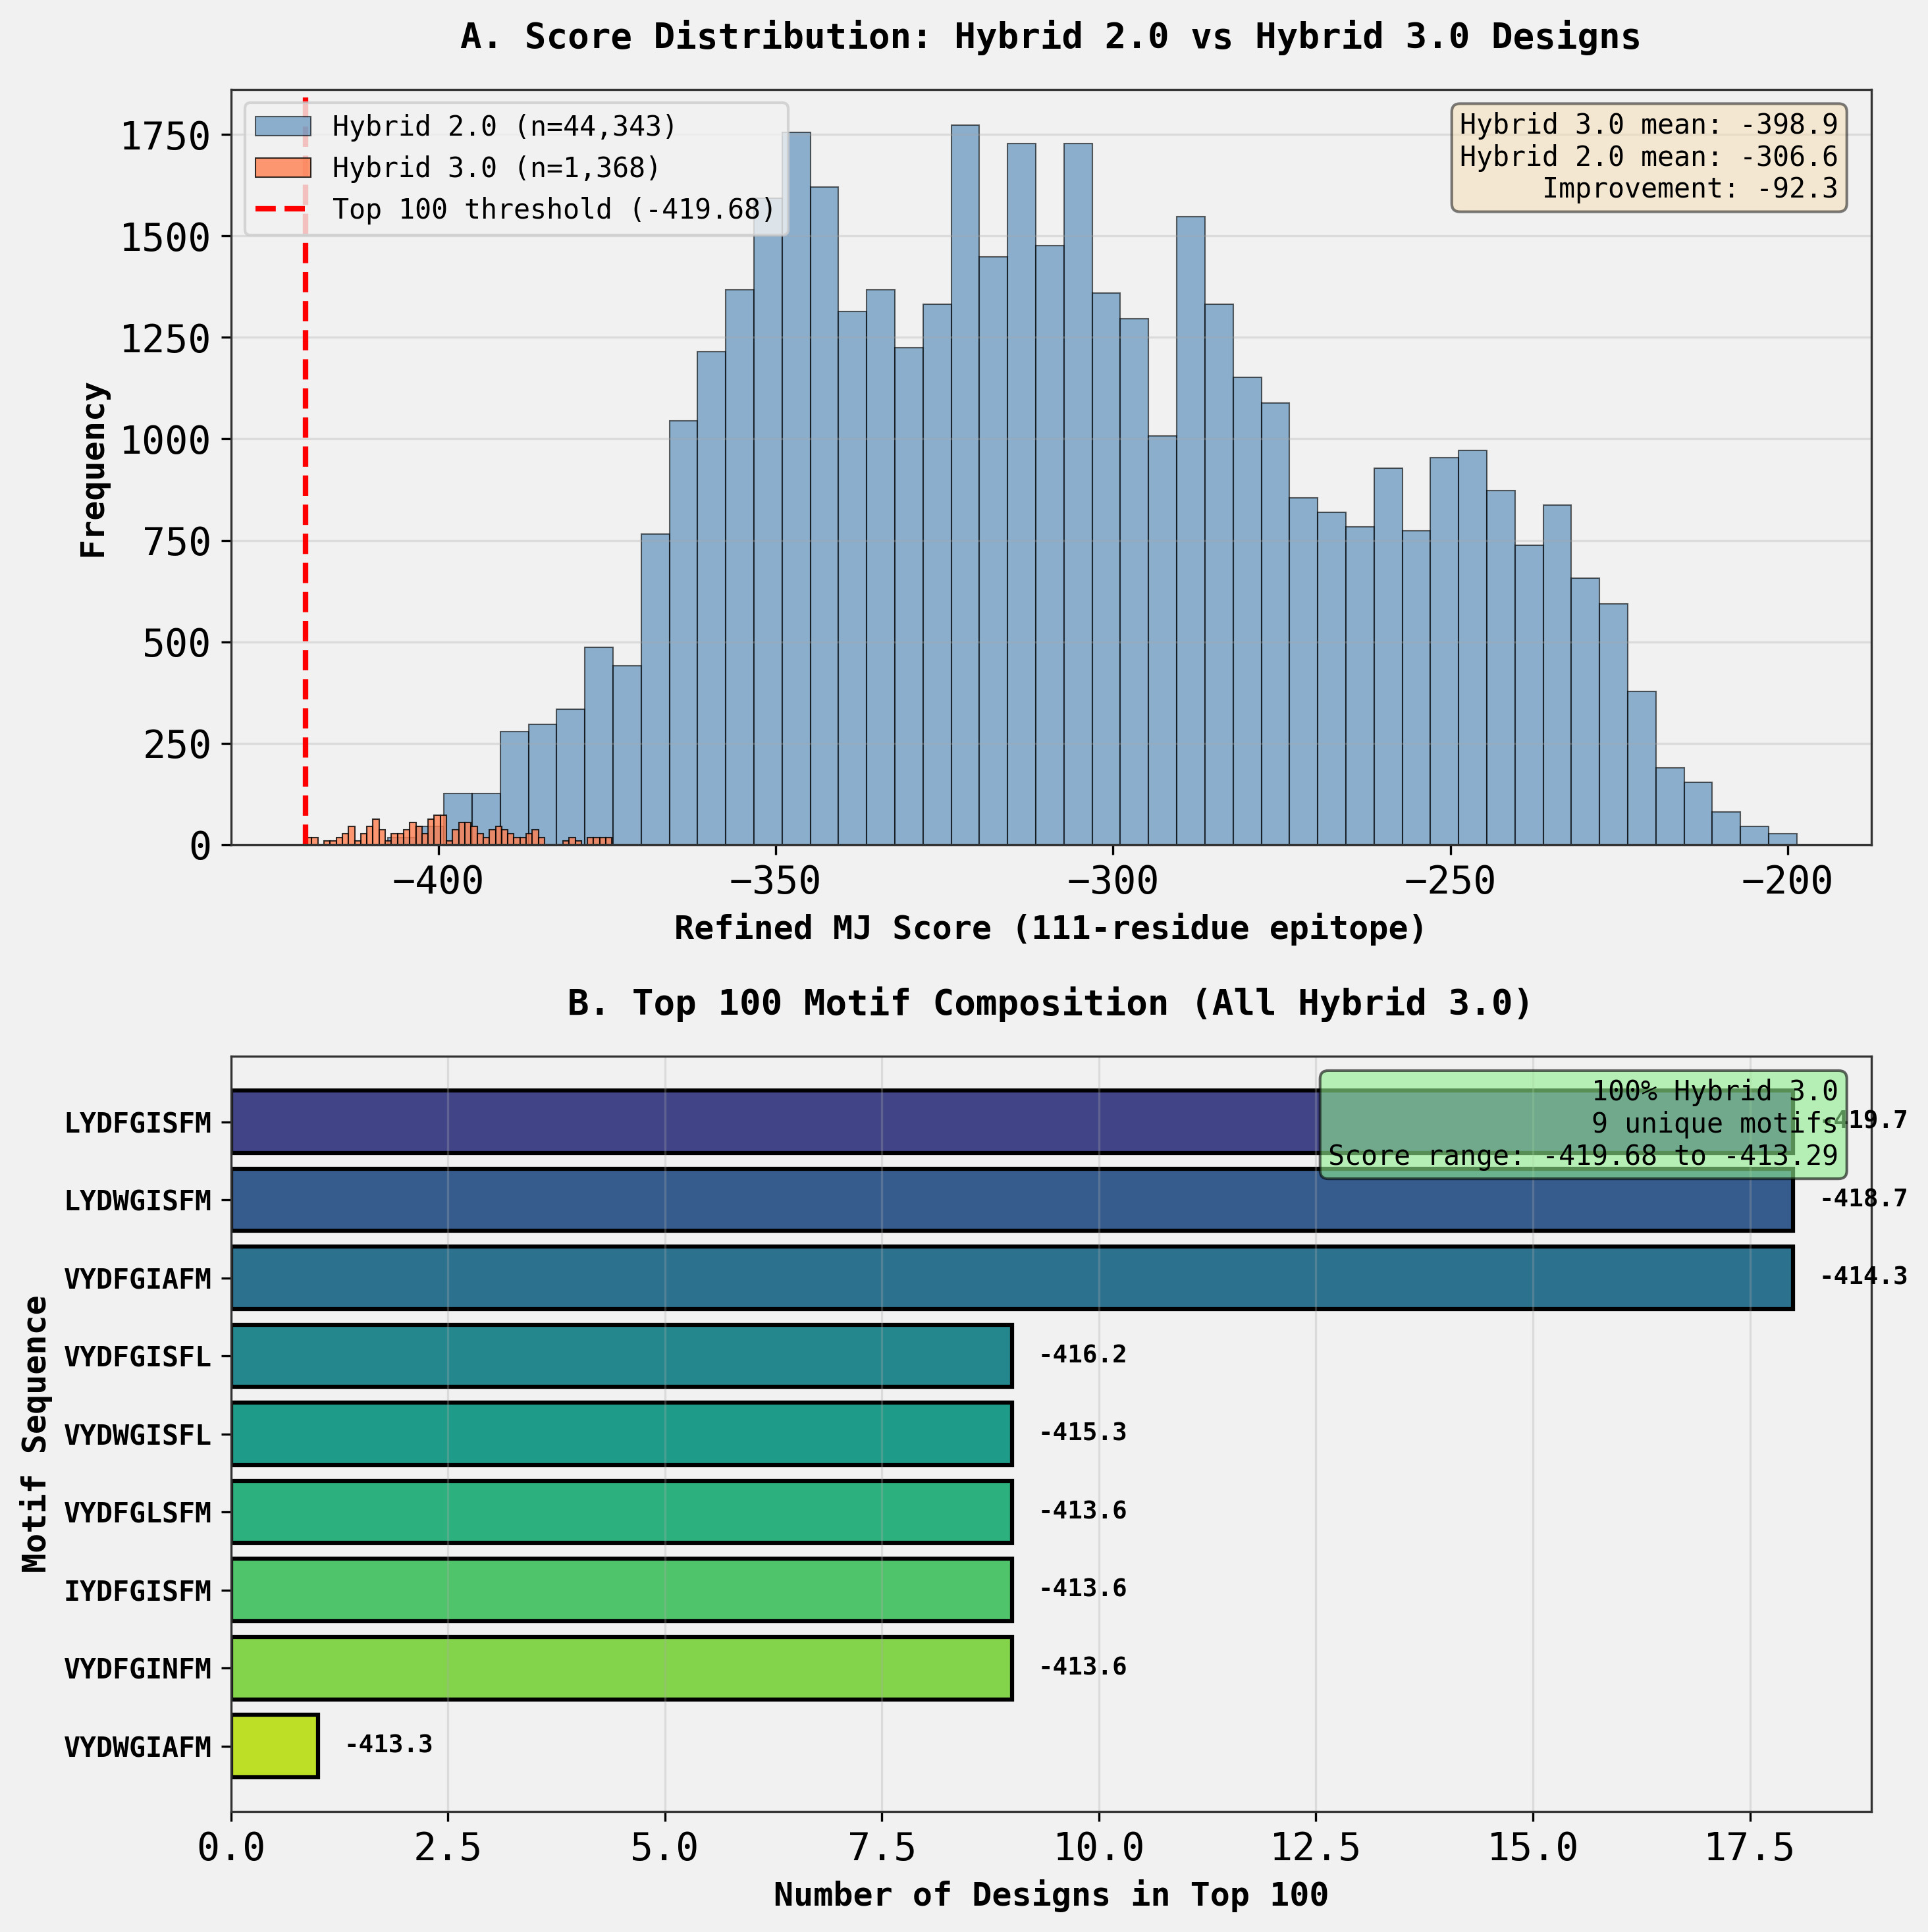


ANALYSIS COMPLETE


In [ ]:

# Create a final summary visualization comparing the two approaches
print("Creating final summary figure...")

# Create figure with two subplots stacked vertically
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(10, 10))

# Subplot A: Score distribution comparison (Hybrid 2.0 vs 3.0)
ax1.hist(hybrid_20_df['Refined_MJ_Score'], bins=50, alpha=0.6, label='Hybrid 2.0 (n=44,343)', 
         color='steelblue', edgecolor='black', linewidth=0.5)
ax1.hist(hybrid_30_df['Refined_MJ_Score'], bins=50, alpha=0.8, label='Hybrid 3.0 (n=1,368)', 
         color='coral', edgecolor='black', linewidth=0.5)
ax1.axvline(top_100_df['Refined_MJ_Score'].min(), color='red', linestyle='--', linewidth=2, 
            label=f'Top 100 threshold ({top_100_df["Refined_MJ_Score"].min():.2f})')
ax1.set_xlabel('Refined MJ Score (111-residue epitope)', fontsize=12, fontweight='bold')
ax1.set_ylabel('Frequency', fontsize=12, fontweight='bold')
ax1.set_title('A. Score Distribution: Hybrid 2.0 vs Hybrid 3.0 Designs', 
              fontsize=13, fontweight='bold', pad=15)
ax1.legend(fontsize=10, loc='upper left')
ax1.grid(axis='y', alpha=0.3)
ax1.text(0.98, 0.97, f'Hybrid 3.0 mean: {h30_scores["mean"]:.1f}\nHybrid 2.0 mean: {h20_scores["mean"]:.1f}\nImprovement: {mean_improvement:.1f}',
         transform=ax1.transAxes, fontsize=10, verticalalignment='top', horizontalalignment='right',
         bbox=dict(boxstyle='round', facecolor='wheat', alpha=0.5))

# Subplot B: Top 100 motif composition
motif_counts_plot = top_100_df['Motif'].value_counts()
colors_motif = plt.cm.viridis(np.linspace(0.2, 0.9, len(motif_counts_plot)))
bars = ax2.barh(range(len(motif_counts_plot)), motif_counts_plot.values, color=colors_motif, 
                edgecolor='black', linewidth=1.5)
ax2.set_yticks(range(len(motif_counts_plot)))
ax2.set_yticklabels(motif_counts_plot.index, fontsize=10, family='monospace', fontweight='bold')
ax2.set_xlabel('Number of Designs in Top 100', fontsize=12, fontweight='bold')
ax2.set_ylabel('Motif Sequence', fontsize=12, fontweight='bold')
ax2.set_title('B. Top 100 Motif Composition (All Hybrid 3.0)', 
              fontsize=13, fontweight='bold', pad=15)
ax2.grid(axis='x', alpha=0.3)
ax2.invert_yaxis()

# Add score annotations to bars
for i, (motif, count) in enumerate(motif_counts_plot.items()):
    score = top_100_df[top_100_df['Motif'] == motif]['Refined_MJ_Score'].iloc[0]
    ax2.text(count + 0.3, i, f'{score:.1f}', va='center', fontsize=9, fontweight='bold')

# Add text summary
summary_text = f'100% Hybrid 3.0\n9 unique motifs\nScore range: -419.68 to -413.29'
ax2.text(0.98, 0.97, summary_text, transform=ax2.transAxes, fontsize=10,
         verticalalignment='top', horizontalalignment='right',
         bbox=dict(boxstyle='round', facecolor='lightgreen', alpha=0.6))

plt.tight_layout()
plt.savefig('final_summary_v3.png', dpi=300, bbox_inches='tight')
print("✓ Final summary figure saved as 'final_summary_v3.png'")
plt.show()

print("\n" + "="*80)
print("ANALYSIS COMPLETE")
print("="*80)
